## Get spatial location of electrodes and neurons on arrays

In [1]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sparse
import warnings 
from scipy import integrate
import seaborn as sns
warnings.simplefilter('ignore')
from sklearn.decomposition import PCA
import scipy.io as sio
import os
from tqdm.auto import tqdm

sns.set_style('white')
# to change default color cycle
cs = ['#081D30', '#D7A928', '#CDB275', '#1C5F69', '#984B3F', '#C23F33', '#2E3D30']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)

import pyaldata as pld # using functions from PyalData
import tools # matlab2python functions

### Functions 

To be implemented in tools.py

In [2]:
def cleanup_text(s):
    ''' Removes .cmp file formatting '''
    for r in (('\t', ' '), ('\n', ''), ('elec', '')):
        s = s.replace(*r)
    s = s.split()        
    return s

In [3]:
def read_cmp(cmp_file):
    '''
    reads Blackrock .cmp file into Python
    
    Parameters
    ----------
    cmp_file: str
        string file path to .cmp file
        
    Returns
    -------
    elec_map: dataframe of shape (96, 5)
        [col (int), row (int), channel number (str), within_channel_num (int), global electrode number (int)]
    '''
    
    f = open(cmp_file)
    # remove comments in file
    temp = [line for line in f.readlines() if not line.startswith('//')] 
    pre_df = [cleanup_text(row) for i, row in enumerate(temp) if not i == 0] 
    df = pd.DataFrame(pre_df, columns=['array_col', 'array_row', 'channel_num', 'within_channel_num', 'global_enum']).dropna()

    # ugly way to convert all possible cols to int.. to be improved
    for i in df.columns:
        try: df[[i]] = df[[i]].astype(str).astype(int) 
        except: pass
    
    return df

In [40]:
def get_electrode_loc(elec_map, elecs, verbose=False):
    '''
    Get location of electrodes on array, displays the array if Verbose=True.
    
    Parameters
    ----------
    elec_map: 
    
    elecs: the electrodes for which you want to get the position
    
    Returns
    -------
    
    A: np.array
        matrix with the spatial position of the electrodes
    '''
    # construct multi electrode array (assuming 10x10)
    A = np.zeros((10,10))
    
    for elec in elecs:
        if elec in elec_map['global_enum'].values:
            # find corresponding row and column in array
            r = int(elec_map.loc[elec_map['global_enum'] == elec]['array_row'])
            c = int(elec_map.loc[elec_map['global_enum'] == elec]['array_col'])
            A[r, c] = elec
        else:
            if verbose:
                print(f'Electrode number {elec} does not exist in array \n')
    
    if verbose: # display array with number of neurons
        fig, ax = plt.subplots(1, figsize=(5,5), dpi=80)
        im = ax.imshow(A, cmap='vlag', interpolation='none', vmin=0, vmax=1, aspect='equal')
        # stuff to annotate the grid and draw white squares around each cell
        def rect(pos):
            r = plt.Rectangle(pos-0.5, 1,1, facecolor='none', edgecolor='w', linewidth=2)
            plt.gca().add_patch(r)
        x,y = np.meshgrid(np.arange(A.shape[1]),np.arange(A.shape[0]))
        m = np.c_[x[A.astype(bool)], y[A.astype(bool)]]
        for pos in m: rect(pos)
        for i in range(len(A)):
                for j in range(len(A)):
                    text = ax.text(j, i, int(A[i, j]), ha='center', va='center', color='w')
 
    return A

In [108]:
def get_neuron_elec_mapping(elec_map, unit_guide, spikes, trial):
    '''
    
    Parameters
    ----------
    elec_map:
    
    unit_guide: 
    
    Returns
    -------
    unit_arr: 

    '''
    elecs = list(range(1, 97)) # total number of electrodes
    unit_arr = np.zeros((10, 10)) # assuming 10x10 array
    neuron_distrib = []
    elecs_to_spikes = {}
    
    # get the spike trains from a particular trial
    spikes_trial_i = spikes[trial]

    for e in elecs:

        # find indices in unit guide of this electrode number 
        e_indices = np.where(unit_guide[:, 0] == e)

        if np.size(e_indices) == 0: # skip if electrode number is not in col
            neuron_distrib.append(0)
            elecs_to_spikes.update({e: np.array([])}) # add empty array?
            continue

        # take neurons that belong to these indices 
        neurons_at_e = max(unit_guide[:, 1][e_indices])

        neuron_distrib.append(neurons_at_e) # largest number is total number of neurons

        arr_idx = np.where(elec_map == e) # get spatial location of electrode
        unit_arr[arr_idx] = neurons_at_e # store number of neurons in array

        # spiketrains of neurons that belong to electrode e
        spikes_elec_k = np.array([spikes_trial_i[:, k] for k in e_indices])[0]

        # append to dictionary with electrode num as key and spiketrains as values
        elecs_to_spikes.update({e:spikes_elec_k})
        
    return neuron_distrib, unit_arr, elecs_to_spikes

In [96]:
def show_array(unit_arr):
    ''' Displays the number of neurons per electrode on array.'''
    
    fig, ax = plt.subplots(1, figsize=(5,5), dpi=80)
    ax.imshow(unit_arr, cmap='Blues')
    for i in range(len(unit_arr)):
        for j in range(len(unit_arr)):
            text = ax.text(j, i, int(unit_arr[i, j]), ha='center', va='center', color='w')

In [117]:
def make_raster(n_spiketrains):
    '''
    Plots a raster given a set of spike trains.
    
    Parameters
    ----------
    n_spiketrains: nd array in the form [# timepoints, # neurons]
        set of binary arrays that represent the spiking behaviour of some neurons
    '''
    if np.size(n_spiketrains) == 0:
        print('This is an empty array')
        return
    
    if n_spiketrains.shape[1] < 2: flen = 1
    else: flen = n_spiketrains.shape[1]/4.5
    
    # convert higher values to ones
    binary_spikes = np.isin(n_spiketrains, [1, 2, 3, 4]).astype(np.uint8) 
    
    # scale length of plot by number of neurons    
    fig, ax = plt.subplots(1, figsize=(12, flen), dpi=80)

    for i in range(n_spiketrains.shape[1]): # for all neurons
        # trick to fix place of spike train
        y_int = i + 1 
        n_i_spiketrain = binary_spikes[:, i] * y_int
        # replace zeros with nan vals for plotting
        n_i_spiketrain = [float('nan') if x==0 else x for x in n_i_spiketrain]

        plt.scatter(range(n_spiketrains.shape[0]), n_i_spiketrain,  marker='|', c='darkblue', s=50);
        ax.set_title(f'Raster plot of {n_spiketrains.shape[1]} neuron(s)', fontsize=15)
        ax.set_xlabel('time', fontsize=13)
        ax.set_ylabel('neuron', fontsize=13)

## Load data

In [118]:
'''
Insert path and filename 
'''
path = '/Users/Daphne/Data/'  
fname = 'Chewie_CO_VR_2016-10-06.mat' 
df = pld.mat2dataframe(path+fname, shift_idx_fields=True)

## Read cmp file

The `.cmp` file contains the location of the electrodes on the array.

We want to know the spatial location of electrodes so that we know the spatial location of the recorded neurons.

Note that, while an array is a 10x10 grid, there are only 96 electrodes on a given array due to hardware constraints. 

By default, omitted electrodes (dead electrodes) are the 4 corner grids. If something goes wrong during fabrication however, this may change.

In [119]:
df_M1 = read_cmp(cmp_file='/Users/Daphne/Desktop/Chewie Left M1 SN 6250-001474.cmp')
df_PMd = read_cmp(cmp_file='/Users/Daphne/Desktop/Chewie Left PMd SN 6251-001469.cmp')

In [120]:
df_M1.shape

(96, 5)

`get_electrode_los()` returns a 10x10 matrix with the position of electrode numbers on the array. 

Set `verbose=True` and it will display the array with the given electrodes in red and the rest blue.

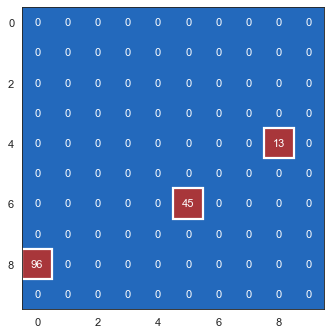

In [121]:
get_electrode_loc(df_M1, elecs=[96, 13, 45], verbose=True);

For the M1 array, we see that indeed all corner squares are omitted.

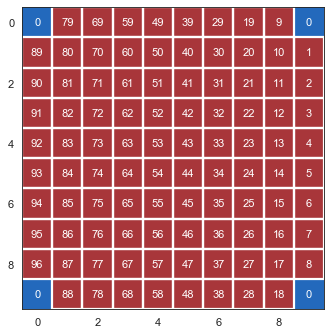

In [122]:
get_electrode_loc(df_M1, elecs=range(1,97), verbose=True);

For the PMd array one dead electrode has a different location.

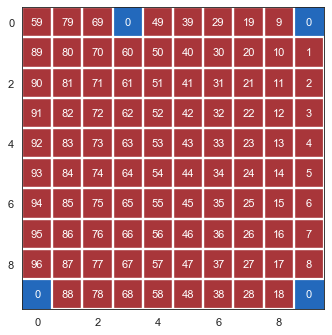

In [123]:
get_electrode_loc(df_PMd, elecs=range(1,97), verbose=True);

The colored grids are just for visualisation purposes, we can use the np arrays to continue.

We have the spatial location of each electrode and we have **unit guides** that specify how many neurons each electrode covers.

Connecting these two, we can get the spatial location of $n$ neurons on the array.

In [124]:
M1_elecmap = get_electrode_loc(df_M1, elecs=range(1,97))
PMd_elecmap = get_electrode_loc(df_PMd, elecs=range(1,97))

In [125]:
PMd_elecmap

array([[59., 79., 69.,  0., 49., 39., 29., 19.,  9.,  0.],
       [89., 80., 70., 60., 50., 40., 30., 20., 10.,  1.],
       [90., 81., 71., 61., 51., 41., 31., 21., 11.,  2.],
       [91., 82., 72., 62., 52., 42., 32., 22., 12.,  3.],
       [92., 83., 73., 63., 53., 43., 33., 23., 13.,  4.],
       [93., 84., 74., 64., 54., 44., 34., 24., 14.,  5.],
       [94., 85., 75., 65., 55., 45., 35., 25., 15.,  6.],
       [95., 86., 76., 66., 56., 46., 36., 26., 16.,  7.],
       [96., 87., 77., 67., 57., 47., 37., 27., 17.,  8.],
       [ 0., 88., 78., 68., 58., 48., 38., 28., 18.,  0.]])

## Unit guides

The unit guides specify the number of neurons per electrode. 

```
[electrode k, neuron 1]
[electrode k, neuron 2]
[electrode k, neuron 3]
[electrode k+1, neuron 1]
etc.
```

While the unit guides are `(774 x N)` (we have a unit guide for each row), they are all equal.

So we can pick an arbitrary row. 

## Spike trains

In `[brain_area]_spikes` the rows indicate the timepoints and the columns the neurons `[timepoints, neurons] = [447, 63]`.

We make a dictionary that serves as a mapping between the neurons on the electrodes and 


In [61]:
#df['M1_unit_guide'][0][:, 0] # the electrodes

Get the distribution of cells, the number of neurons per electrode in an array, and a mapping between each electrode and the spike trains of the neurons at that location

In [109]:
cell_distribution_M1, cell_locs_M1, espike_dict_M1 = get_neuron_elec_mapping(M1_elecmap, df['M1_unit_guide'][0], spikes=df['M1_spikes'], trial=0)

cell_distribution_PMd, cell_locs_PMd, espike_dict_PMd = get_neuron_elec_mapping(PMd_elecmap, df['PMd_unit_guide'][0], spikes=df['PMd_spikes'], trial=0);

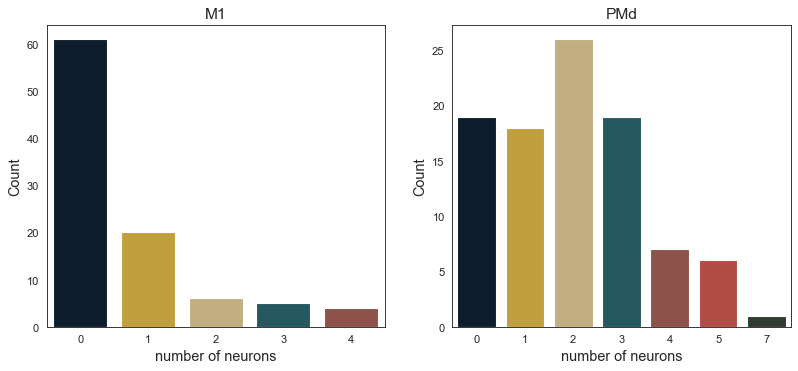

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), dpi=80)

sns.countplot(x=cell_distribution_M1, ax=ax1)
ax1.set_title('M1', fontsize=14)
ax1.set_xlabel('number of neurons', fontsize=13)
ax1.set_ylabel('Count', fontsize=13)

sns.countplot(x=cell_distribution_PMd, ax=ax2)
ax2.set_title('PMd', fontsize=14)
ax2.set_xlabel('number of neurons', fontsize=13)
ax2.set_ylabel('Count', fontsize=13);

This shows the number of neurons each electrode covers on the M1 array... why are there so many electrodes without neurons?

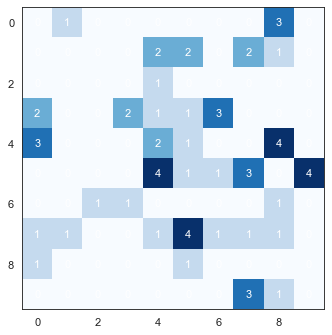

In [63]:
show_array(cell_locs_M1)

The PMd array looks much better 

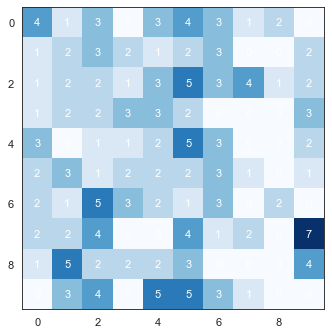

In [64]:
show_array(cell_locs_PMd)

In [65]:
sum(cell_distribution_M1) # total number of neurons on M1 arr

63

In [66]:
sum(cell_distribution_PMd) # total number of neurons on PMd arr

192

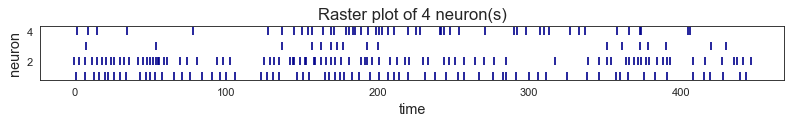

In [115]:
make_raster(espike_dict_M1[5])

In [127]:
for key, value in espike_dict_M1.items():
    print(key, value.shape)

1 (0,)
2 (0,)
3 (0,)
4 (0,)
5 (447, 4)
6 (0,)
7 (0,)
8 (0,)
9 (447, 3)
10 (447, 1)
11 (0,)
12 (0,)
13 (447, 4)
14 (0,)
15 (447, 1)
16 (447, 1)
17 (0,)
18 (447, 1)
19 (0,)
20 (447, 2)
21 (0,)
22 (0,)
23 (0,)
24 (447, 3)
25 (0,)
26 (447, 1)
27 (0,)
28 (447, 3)
29 (0,)
30 (0,)
31 (0,)
32 (447, 3)
33 (0,)
34 (447, 1)
35 (0,)
36 (447, 1)
37 (0,)
38 (0,)
39 (0,)
40 (447, 2)
41 (0,)
42 (447, 1)
43 (447, 1)
44 (447, 1)
45 (0,)
46 (447, 4)
47 (447, 1)
48 (0,)
49 (0,)
50 (447, 2)
51 (447, 1)
52 (447, 1)
53 (447, 2)
54 (447, 4)
55 (0,)
56 (447, 1)
57 (0,)
58 (0,)
59 (0,)
60 (0,)
61 (0,)
62 (447, 2)
63 (0,)
64 (0,)
65 (447, 1)
66 (0,)
67 (0,)
68 (0,)
69 (0,)
70 (0,)
71 (0,)
72 (0,)
73 (0,)
74 (0,)
75 (447, 1)
76 (0,)
77 (0,)
78 (0,)
79 (447, 1)
80 (0,)
81 (0,)
82 (0,)
83 (0,)
84 (0,)
85 (0,)
86 (447, 1)
87 (0,)
88 (0,)
89 (0,)
90 (0,)
91 (447, 2)
92 (447, 3)
93 (0,)
94 (0,)
95 (447, 1)
96 (447, 1)


In [128]:
for key, value in espike_dict_PMd.items():
    print(key, value.shape)

1 (447, 2)
2 (447, 2)
3 (447, 3)
4 (447, 2)
5 (447, 1)
6 (0,)
7 (447, 7)
8 (447, 4)
9 (447, 2)
10 (0,)
11 (447, 1)
12 (0,)
13 (0,)
14 (0,)
15 (447, 2)
16 (0,)
17 (0,)
18 (0,)
19 (447, 1)
20 (0,)
21 (447, 4)
22 (0,)
23 (0,)
24 (447, 1)
25 (0,)
26 (447, 2)
27 (0,)
28 (447, 1)
29 (447, 3)
30 (447, 3)
31 (447, 3)
32 (0,)
33 (447, 3)
34 (447, 3)
35 (447, 3)
36 (447, 1)
37 (0,)
38 (447, 3)
39 (447, 4)
40 (447, 2)
41 (447, 5)
42 (447, 2)
43 (447, 5)
44 (447, 2)
45 (447, 1)
46 (447, 4)
47 (447, 3)
48 (447, 5)
49 (447, 3)
50 (447, 1)
51 (447, 3)
52 (447, 3)
53 (447, 2)
54 (447, 2)
55 (447, 2)
56 (0,)
57 (447, 2)
58 (447, 5)
59 (447, 4)
60 (447, 2)
61 (447, 1)
62 (447, 3)
63 (447, 1)
64 (447, 2)
65 (447, 3)
66 (0,)
67 (447, 2)
68 (0,)
69 (447, 3)
70 (447, 3)
71 (447, 2)
72 (447, 2)
73 (447, 1)
74 (447, 1)
75 (447, 5)
76 (447, 4)
77 (447, 2)
78 (447, 4)
79 (447, 1)
80 (447, 2)
81 (447, 2)
82 (447, 2)
83 (0,)
84 (447, 3)
85 (447, 1)
86 (447, 2)
87 (447, 5)
88 (447, 3)
89 (447, 1)
90 (447, 1)
91 (4

In [130]:
df = pd.DataFrame(espike_dict_M1[5])

In [131]:
df

,0,1,2,3
0,0,1,0,0
1,1,0,0,0
2,0,0,0,1
3,0,1,0,0
4,0,0,0,0
...,...,...,...,...
442,0,0,0,0
443,1,0,0,0
444,0,0,0,0
445,0,0,0,0


## Old

//   legend					

//   col - 0 based column from left to right					

//   row - 0 based row from bottom to top					

//   bank - bank name - values can be A B C or D					

//   elec - 1 based electrode number within the bank - values can be 1-32					

//   label - label used to rename channels in Central (optional)					

Cerebus mapping for array 13965-21    SN: 6250-001474				

In [ ]:
#     if verbose:
#         fig, ax = plt.subplots(1, figsize=(6,6), dpi=80)
#         sns.heatmap(A, cmap='vlag', annot=True, vmin=0, vmax=1, cbar=False, ax=ax, linewidths=.5)
        

In [ ]:
# #to check equality or rows (.unique did not work)
# for i in range(700):
#     if not np.array_equal(df['M1_unit_guide'][0], df['M1_unit_guide'][i]):
#         print('not equal')

In [307]:
# unit_guide = df['M1_unit_guide'][0]
# elec_map = M1_elecmap

# elecs = list(range(1, 97)) # total number of electrodes
# unit_arr = np.zeros((10, 10)) # assuming 10x10 array
# neuron_distrib = []
# elecs_to_spikes = {}

# for e in elecs:
    
#     # find indices in unit guide of this electrode number 
#     e_indices = np.where(unit_guide[:, 0] == e)

#     if np.size(e_indices) == 0: # skip if electrode number is not in col
#         neuron_distrib.append(0)
#         elecs_to_spikes.update({e: np.array(0)}) # empty array?
#         continue

#     # take neurons that belong to these indices 
#     neurons_at_e = max(unit_guide[:, 1][e_indices])
    
#     neuron_distrib.append(neurons_at_e) # largest number is total number of neurons

#     arr_idx = np.where(elec_map == e) # get spatial location of electrode
#     unit_arr[arr_idx] = neurons_at_e # store number of neurons in array
    
#     # spiketrains of neurons that belong to electrode e
#     spikes_elec_k = np.array([spikes_trial_i[:, k] for k in e_indices])[0]

#     # append to dictionary with electrode num as key and spiketrains as values
#     elecs_to_spikes.update({e:spikes_elec_k})